In [1]:
%matplotlib notebook

from util import (
    
    PairwiseDiffDataset,
    VideoDataset,
    ImageDataset,
    create_train_test_sets, 
    init_train_test_sets,
    run_training,
    evaluate,
    initialize_model,
    get_model_path
)


import numpy as np
import warnings
import os
import torch
import torch.nn as nn
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)



In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# data and model dirs
root_dir = 'data/nontemp/faces/'
root_dir_aug = 'data/nontemp/faces_aug/'


In [4]:
# train params
dropout = 0.3
lr = 1e-4
wd = 1e-4
reduce_lr_on_plateau = True
batch_size = 20
num_epochs = 20
show_plots = True
num_workers = 2 # CHECK WHETHER REDUCING HELPS
joint_training = False

## Configuration

In the next cell we specify which model we want to train. 
Available models are:

**Image-based:** 
1. MesoNet4 
2. EfficientNet B3

**Video-based:**

3. MesoNet4 + LSTM
4. EfficientNet B0 + LSTM


Next to this we want to choose whether to use a model trained on either clean data or data augmented using perturbations.

In [5]:
# init model
"""
model = 2
model_class = get_model_path(model)
"""
path_to_model = 'logs/checkpoints/effb0_do0.3_wd0.0001_lr0.0001_dataclean/'
from_checkpoint = 10

model_class = 'effb0'
model, temporal = initialize_model(model_class, pretrained=False, device=device, dropout=dropout)

# if resume training
model.load_state_dict(torch.load(path_to_model + f'checkpoint-{10}.pth.tar')['model'])
model.to(device)

# set model names and log dir specific to the current run
model_name = f'effb0_do{dropout}_wd{wd}_lr{lr}_data{"joint" if joint_training else "clean"}'
log_dir = f"logs/checkpoints/{model_name}/"


In [6]:
type_model = 'image' if not temporal else 'video'

In [7]:
# init datasets
trainset, valset, testset = init_train_test_sets(root_dir=root_dir,
                                        joint_training=joint_training,
                                        second_root_dir=root_dir_aug,
                                        type_model=type_model)


Sucessfully created non-temporal versions of training, validation and test sets.
Length of training data: 152023
Length of validation data: 19264
Length of testing data: 19510


<IPython.core.display.Javascript object>


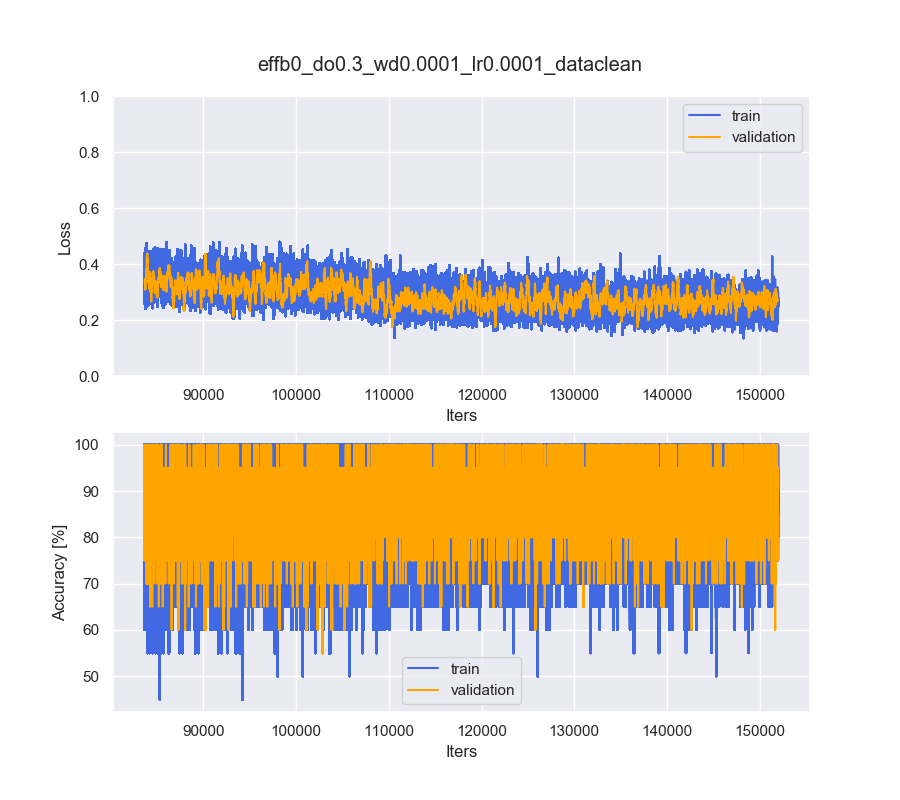

epoch:  11
[Epoch: 12/20] [Mean acc train/val: 0.852/0.856] [Mean loss train/val: 0.335/0.330] [F1/Precision/Recall:  0.846/ 0.848/ 0.870]
epoch:  12
[Epoch: 13/20] [Mean acc train/val: 0.856/0.864] [Mean loss train/val: 0.324/0.317] [F1/Precision/Recall:  0.847/ 0.854/ 0.880]
epoch:  13
[Epoch: 14/20] [Mean acc train/val: 0.862/0.864] [Mean loss train/val: 0.315/0.316] [F1/Precision/Recall:  0.860/ 0.856/ 0.869]
epoch:  14
Epoch     4: reducing learning rate of group 0 to 1.0000e-05.
[Epoch: 15/20] [Mean acc train/val: 0.879/0.884] [Mean loss train/val: 0.278/0.274] [F1/Precision/Recall:  0.873/ 0.876/ 0.891]
epoch:  15
[Epoch: 16/20] [Mean acc train/val: 0.884/0.887] [Mean loss train/val: 0.268/0.269] [F1/Precision/Recall:  0.878/ 0.879/ 0.891]
epoch:  16
[Epoch: 17/20] [Mean acc train/val: 0.885/0.887] [Mean loss train/val: 0.264/0.269] [F1/Precision/Recall:  0.880/ 0.880/ 0.892]
epoch:  17
Epoch     7: reducing learning rate of group 0 to 1.0000e-06.
[Epoch: 18/20] [Mean acc train/

In [8]:
# run training
val_loss, val_acc, train_loss, train_acc = run_training(model=model,
                                                        batch_size=batch_size,
                                                        num_epochs=num_epochs,
                                                        train_dataset=trainset,
                                                        device=device,
                                                        title=model_name,
                                                        validation_dataset=valset,
                                                        lr=lr,
                                                        weight_decay=wd,
                                                        show_plots=show_plots,
                                                        num_workers=num_workers,
                                                        log_dir=log_dir,
                                                        reduce_lr_on_plateau=reduce_lr_on_plateau,
                                                        epoch=from_checkpoint+1)

[Test acc: 0.874]


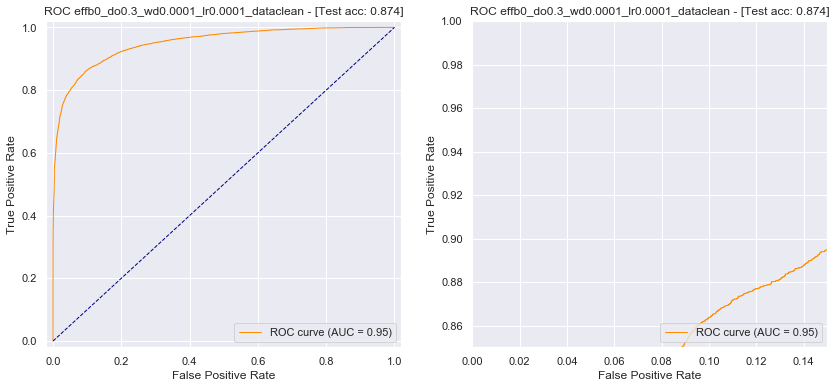

0.8740133264992314

In [9]:
%matplotlib inline
# run eval
evaluate(model=model,
         test_set=testset,
         batch_size=10, 
         title="ROC "+model_name,
         device=device)
